In [ ]:
import os
import requests
from datetime import datetime
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from datetime import timedelta

# Load environment variables
load_dotenv()
TOKEN = os.getenv('GRAPH_GITHUB_TOKEN')
OWNER = os.getenv('GRAPH_REPO_OWNER')
REPO = os.getenv('GRAPH_REPO_NAME')

# GitHub API headers
headers = {
    "Authorization": f"token {TOKEN}",
    "Accept": "application/vnd.github.v3+json"
}

ALLOWED_AUTHORS =["Mads Knudsen", "Mfknudsen", "SMerved", "Søren Dollerup Merved", "KurisuDaNoda", "krisdanoda", "Kristofer Noda Pedersen", "MagicalGlove","Magical Glove", "Michael Frederiksen"]

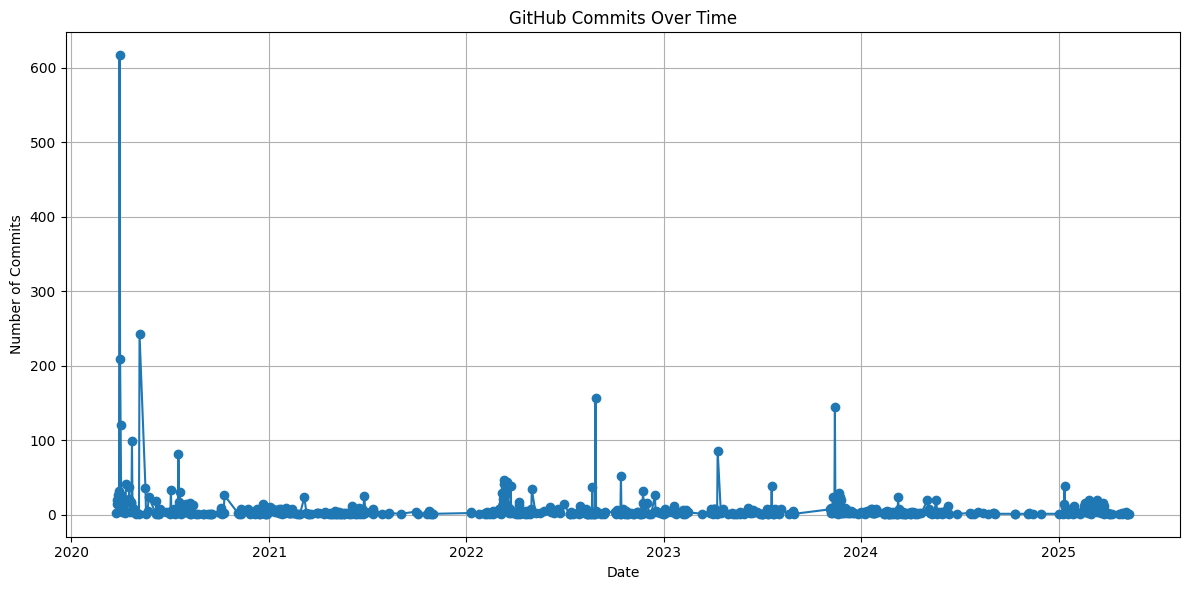

In [54]:
# Get commits from the GitHub API
def get_commits(owner, repo):
    commits = []
    page = 1
    while True:
        url = f"https://api.github.com/repos/{owner}/{repo}/commits?page={page}&per_page=100"
        response = requests.get(url, headers=headers)
        data = response.json()
        if not data or response.status_code != 200:
            break
        commits.extend(data)
        page += 1
    return commits

# Extract commit dates (in YYYY-MM-DD)
def extract_dates(commits):
    dates = [
        commit['commit']['author']['date'][:10]
        for commit in commits
    ]
    return dates

# Count commits per date
def count_commits_by_date(dates):
    counter = Counter(dates)
    return sorted(counter.items())

# Plot the graph
def plot_commit_history(commit_data):
    dates, counts = zip(*commit_data)
    dates = [datetime.strptime(date, "%Y-%m-%d") for date in dates]
    plt.figure(figsize=(12, 6))
    plt.plot(dates, counts, marker='o')
    plt.title("GitHub Commits Over Time")
    plt.xlabel("Date")
    plt.ylabel("Number of Commits")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

commits = get_commits(OWNER, REPO)
dates = extract_dates(commits)
commit_data = count_commits_by_date(dates)
plot_commit_history(commit_data)


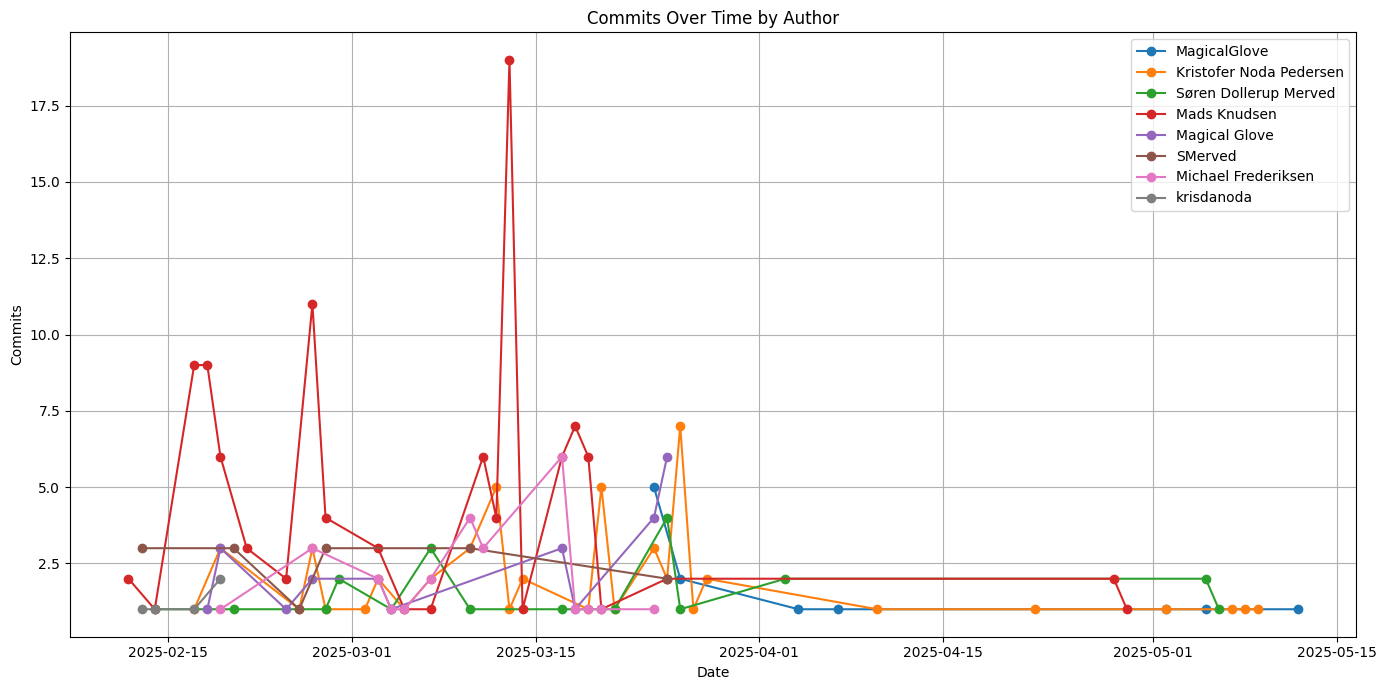

In [55]:
# Get commits from GitHub
def get_commits(owner, repo):
    commits = []
    page = 1
    while True:
        url = f"https://api.github.com/repos/{owner}/{repo}/commits?page={page}&per_page=100"
        response = requests.get(url, headers=headers)
        data = response.json()
        if not data or response.status_code != 200:
            break
        commits.extend(data)
        page += 1
    return commits

# Extract (author, date) tuples
def extract_author_dates(commits):
    author_dates = []
    for commit in commits:
        try:
            author = commit['commit']['author']['name']
            if author in ALLOWED_AUTHORS:
                date = commit['commit']['author']['date'][:10]  # YYYY-MM-DD
                author_dates.append((author, date))
        except KeyError:
            continue
    return author_dates

# Count commits per author per date
def count_commits_by_author_date(author_dates):
    author_date_counts = defaultdict(Counter)
    for author, date in author_dates:
        author_date_counts[author][date] += 1
    return author_date_counts

# Plot commits over time per author
def plot_commits(author_date_counts):
    plt.figure(figsize=(14, 7))

    for author, date_counts in author_date_counts.items():
        dates = sorted(date_counts)
        values = [date_counts[date] for date in dates]
        date_objs = [datetime.strptime(date, "%Y-%m-%d") for date in dates]
        plt.plot(date_objs, values, label=author, marker='o')

    plt.title("Commits Over Time by Author")
    plt.xlabel("Date")
    plt.ylabel("Commits")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

commits = get_commits(OWNER, REPO)
author_dates = extract_author_dates(commits)
author_date_counts = count_commits_by_author_date(author_dates)
plot_commits(author_date_counts)

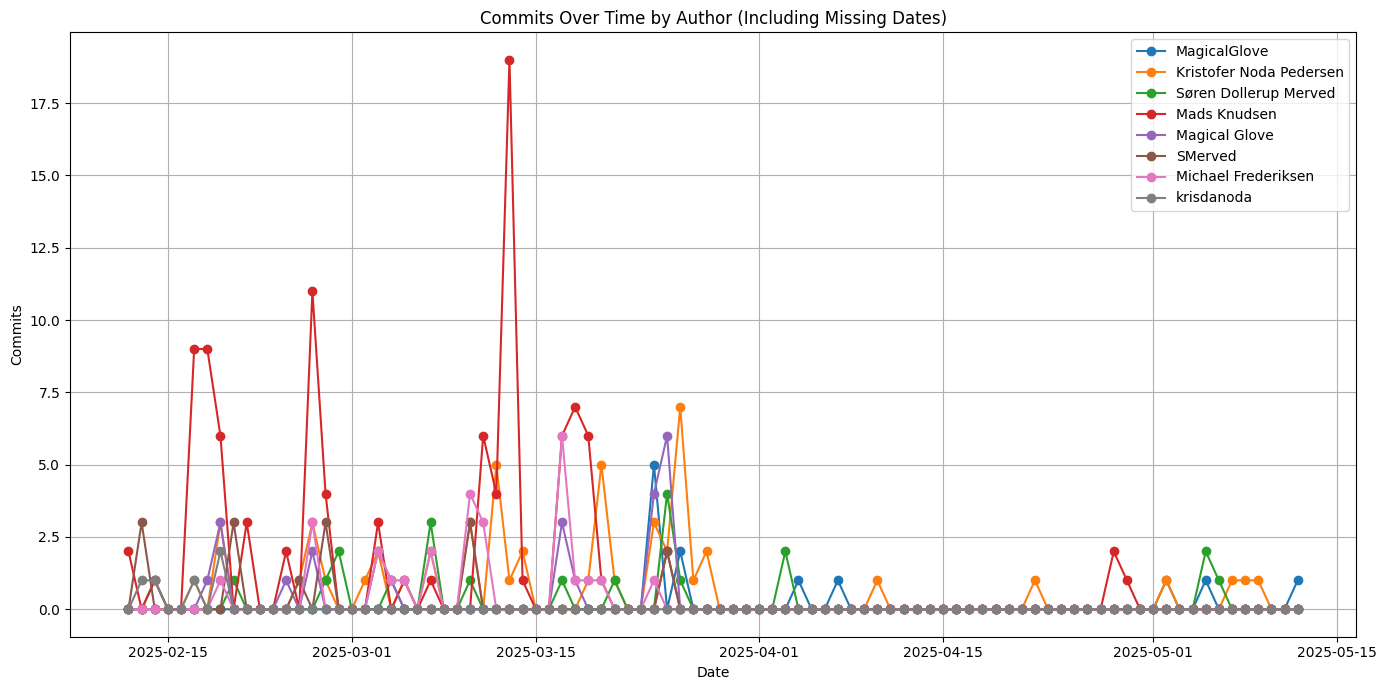

In [ ]:

# Fill missing dates with 0 values
def fill_missing_dates(author_date_counts):
    # Determine the full range of dates
    all_dates = set()
    for date_counts in author_date_counts.values():
        all_dates.update(date_counts.keys())
    all_dates = sorted(all_dates)  # Sort dates in ascending order

    # Create a complete date range from the earliest to the latest date
    if not all_dates:
        return author_date_counts  # Return as-is if no data
    start_date = datetime.strptime(all_dates[0], "%Y-%m-%d")
    end_date = datetime.strptime(all_dates[-1], "%Y-%m-%d")
    full_date_range = [(start_date + timedelta(days=i)).strftime("%Y-%m-%d")
                       for i in range((end_date - start_date).days + 1)]

    # Fill missing dates with 0 for each author
    for author, date_counts in author_date_counts.items():
        for date in full_date_range:
            if date not in date_counts:
                date_counts[date] = 0

    return author_date_counts

# Updated plotting function
def plot_commits_with_filled_dates(author_date_counts):
    plt.figure(figsize=(14, 7))

    for author, date_counts in author_date_counts.items():
        dates = sorted(date_counts)
        values = [date_counts[date] for date in dates]
        date_objs = [datetime.strptime(date, "%Y-%m-%d") for date in dates]
        plt.plot(date_objs, values, label=author, marker='o')

    plt.title("Commits Over Time by Author (Including Missing Dates)")
    plt.xlabel("Date")
    plt.ylabel("Commits")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Process and plot
commits = get_commits(OWNER, REPO)
author_dates = extract_author_dates(commits)
author_date_counts = count_commits_by_author_date(author_dates)
filled_author_date_counts = fill_missing_dates(author_date_counts)
plot_commits_with_filled_dates(filled_author_date_counts)

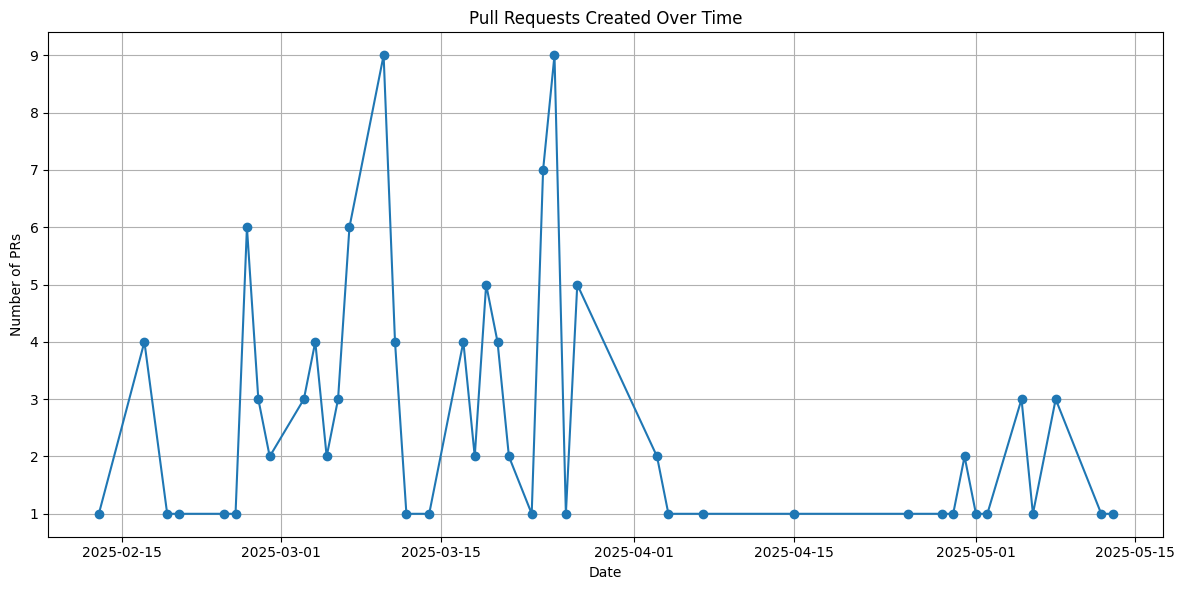

In [57]:
# Get pull requests (open + closed)
def get_pull_requests(owner, repo, max_pages=100):
    prs = []
    page = 1
    while page <= max_pages:
        url = f"https://api.github.com/repos/{owner}/{repo}/pulls?state=all"
        params = {
            "per_page": 100,
            "page": page
        }
        response = requests.get(url, headers=headers, params=params)
        if response.status_code != 200:
            break
        data = response.json()
        if not data:
            break
        prs.extend(data)
        page += 1
    return prs

# Extract creation dates (YYYY-MM-DD) from PRs
def extract_pr_dates(prs):
    return [pr["created_at"][:10] for pr in prs if "created_at" in pr]

# Count PRs per date
def count_prs_by_date(dates):
    counter = Counter(dates)
    return sorted(counter.items())

# Plot PRs over time
def plot_prs_over_time(pr_data):
    if not pr_data:
        print("No pull request data to plot.")
        return
    dates, counts = zip(*pr_data)
    dates = [datetime.strptime(date, "%Y-%m-%d") for date in dates]
    plt.figure(figsize=(12, 6))
    plt.plot(dates, counts, marker='o', linestyle='-')
    plt.title("Pull Requests Created Over Time")
    plt.xlabel("Date")
    plt.ylabel("Number of PRs")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Run full process
prs = get_pull_requests(OWNER, REPO)
pr_dates = extract_pr_dates(prs)
pr_data = count_prs_by_date(pr_dates)
plot_prs_over_time(pr_data)

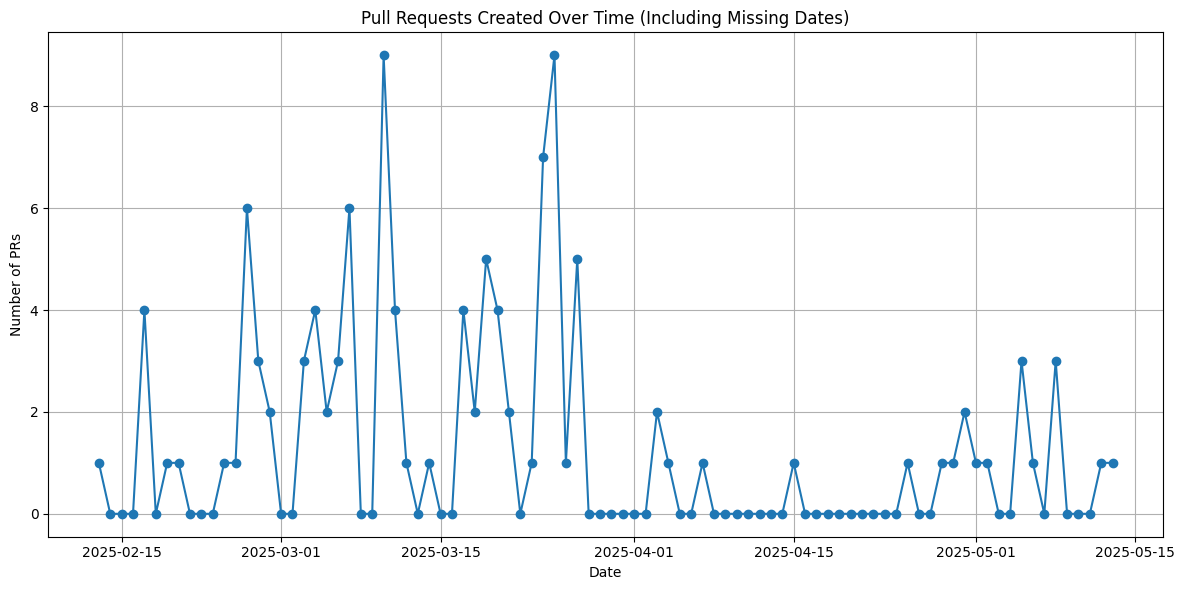

In [ ]:

def fill_missing_pr_dates(pr_date_counts):
    # Determine the full range of dates
    all_dates = set(pr_date_counts.keys())
    all_dates = sorted(all_dates)  # Sort dates in ascending order

    # Create a complete date range from the earliest to the latest date
    if not all_dates:
        return pr_date_counts  # Return as-is if no data
    start_date = datetime.strptime(all_dates[0], "%Y-%m-%d")
    end_date = datetime.strptime(all_dates[-1], "%Y-%m-%d")
    full_date_range = [(start_date + timedelta(days=i)).strftime("%Y-%m-%d")
                       for i in range((end_date - start_date).days + 1)]

    # Fill missing dates with 0
    for date in full_date_range:
        if date not in pr_date_counts:
            pr_date_counts[date] = 0

    return pr_date_counts

def plot_prs_with_filled_dates(pr_date_counts):
    if not pr_date_counts:
        print("No pull request data to plot.")
        return
    dates = sorted(pr_date_counts)
    counts = [pr_date_counts[date] for date in dates]
    date_objs = [datetime.strptime(date, "%Y-%m-%d") for date in dates]
    plt.figure(figsize=(12, 6))
    plt.plot(date_objs, counts, marker='o', linestyle='-')
    plt.title("Pull Requests Created Over Time (Including Missing Dates)")
    plt.xlabel("Date")
    plt.ylabel("Number of PRs")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

prs = get_pull_requests(OWNER, REPO)
pr_dates = extract_pr_dates(prs)
pr_date_counts = dict(Counter(pr_dates))  # Convert to dictionary for easier manipulation
filled_pr_date_counts = fill_missing_pr_dates(pr_date_counts)
plot_prs_with_filled_dates(filled_pr_date_counts)

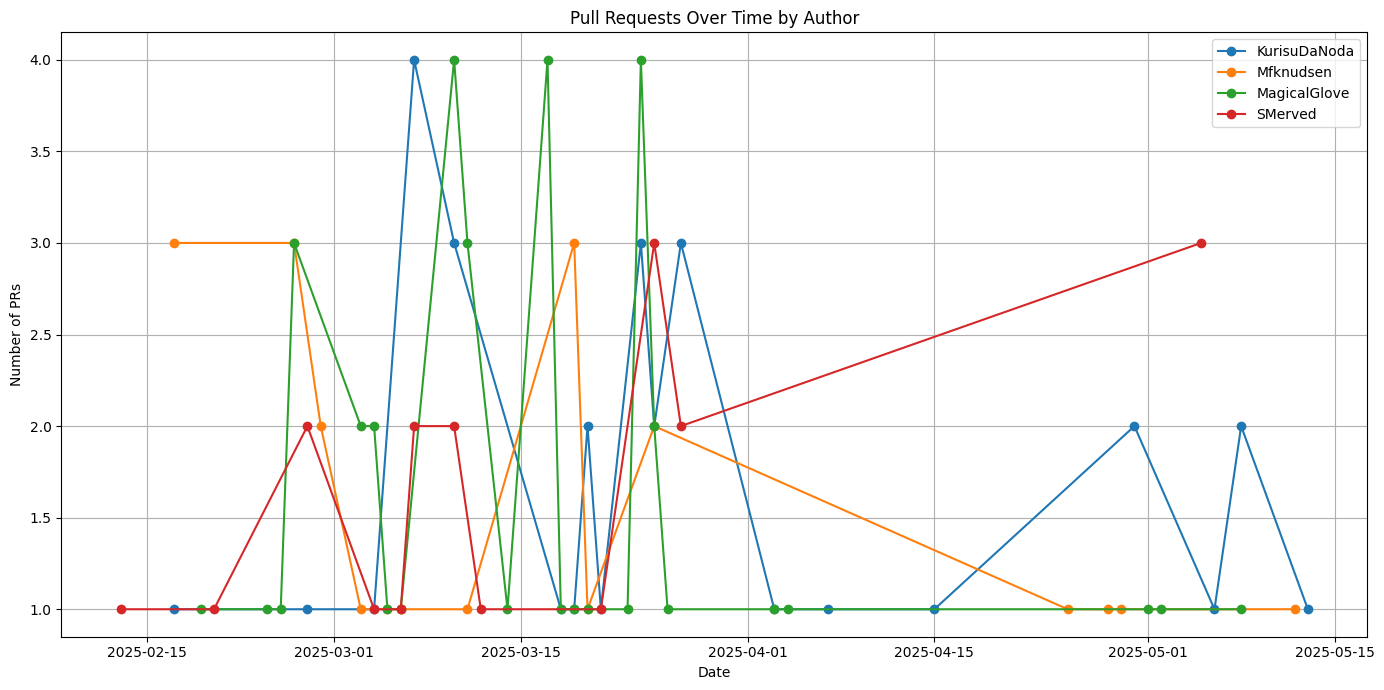

In [59]:
# Get pull requests (open + closed)
def get_pull_requests(owner, repo, max_pages=100):
    prs = []
    page = 1
    while page <= max_pages:
        url = f"https://api.github.com/repos/{owner}/{repo}/pulls?state=all"
        params = {
            "per_page": 100,
            "page": page
        }
        response = requests.get(url, headers=headers, params=params)
        if response.status_code != 200:
            break
        data = response.json()
        if not data:
            break
        prs.extend(data)
        page += 1
    return prs

# Extract (author, date, state) for PRs
def extract_author_pr_dates(prs):
    author_dates = []
    for pr in prs:
        if pr.get("user") and pr["user"]["login"]:
            author = pr["user"]["login"]
            if author in ALLOWED_AUTHORS:
                date_str = pr["created_at"][:10]  # YYYY-MM-DD
                author_dates.append((author, date_str))
    return author_dates

# Count PRs per author per date (optionally grouped by state)
def count_prs_by_author_date(author_dates):
    author_date_counts = defaultdict(lambda: Counter())
    for author, date in author_dates:
        key = author
        author_date_counts[key][date] += 1
    return author_date_counts

# Plot PRs over time per author
def plot_prs(author_date_counts):
    plt.figure(figsize=(14, 7))
    for author, date_counts in author_date_counts.items():
        dates = sorted(date_counts)
        counts = [date_counts[date] for date in dates]
        date_objs = [datetime.strptime(date, "%Y-%m-%d") for date in dates]
        plt.plot(date_objs, counts, label=author, marker='o')

    plt.title("Pull Requests Over Time by Author")
    plt.xlabel("Date")
    plt.ylabel("Number of PRs")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

prs = get_pull_requests(OWNER, REPO)
author_dates = extract_author_pr_dates(prs)
author_date_counts = count_prs_by_author_date(author_dates)
plot_prs(author_date_counts)

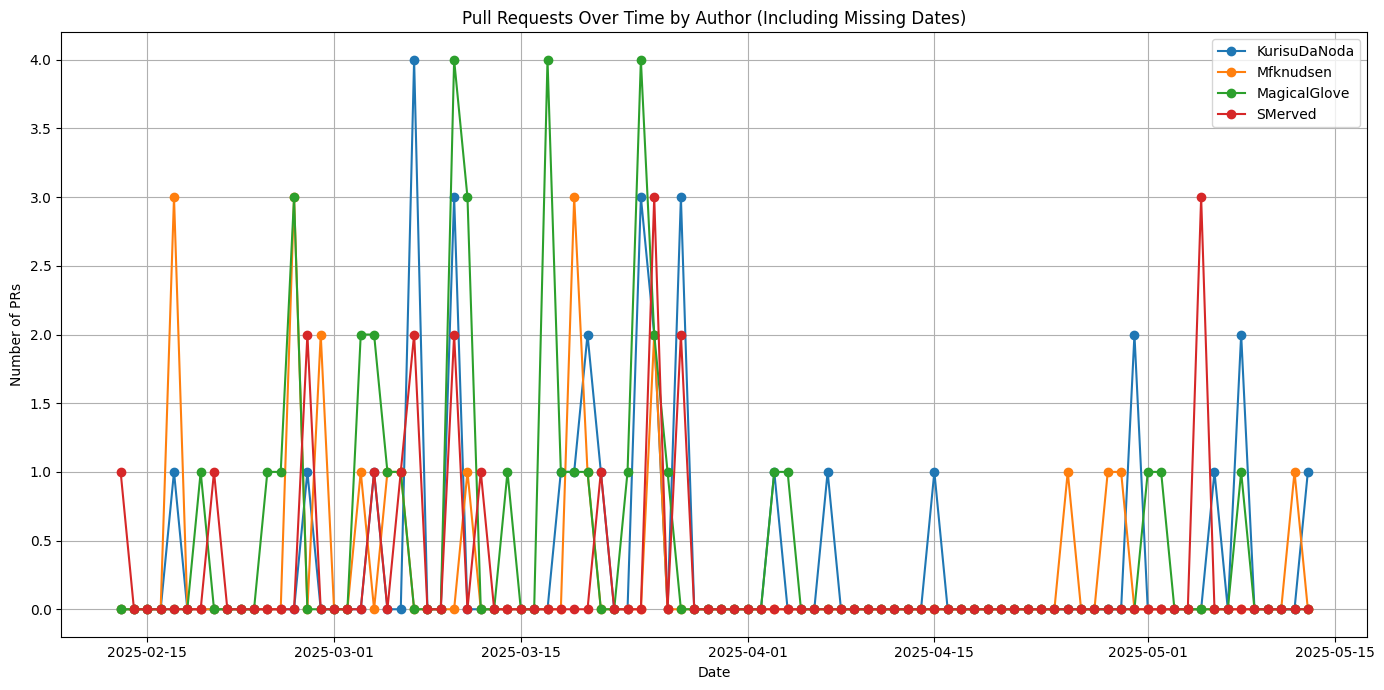

In [ ]:

def fill_missing_pr_dates_by_author(author_date_counts):
    # Determine the full range of dates
    all_dates = set()
    for date_counts in author_date_counts.values():
        all_dates.update(date_counts.keys())
    all_dates = sorted(all_dates)  # Sort dates in ascending order

    # Create a complete date range from the earliest to the latest date
    if not all_dates:
        return author_date_counts  # Return as-is if no data
    start_date = datetime.strptime(all_dates[0], "%Y-%m-%d")
    end_date = datetime.strptime(all_dates[-1], "%Y-%m-%d")
    full_date_range = [(start_date + timedelta(days=i)).strftime("%Y-%m-%d")
                       for i in range((end_date - start_date).days + 1)]

    # Fill missing dates with 0 for each author
    for author, date_counts in author_date_counts.items():
        for date in full_date_range:
            if date not in date_counts:
                date_counts[date] = 0

    return author_date_counts

def plot_prs_with_filled_dates(author_date_counts):
    plt.figure(figsize=(14, 7))

    for author, date_counts in author_date_counts.items():
        dates = sorted(date_counts)
        counts = [date_counts[date] for date in dates]
        date_objs = [datetime.strptime(date, "%Y-%m-%d") for date in dates]
        plt.plot(date_objs, counts, label=author, marker='o')

    plt.title("Pull Requests Over Time by Author (Including Missing Dates)")
    plt.xlabel("Date")
    plt.ylabel("Number of PRs")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

prs = get_pull_requests(OWNER, REPO)
author_dates = extract_author_pr_dates(prs)
author_date_counts = count_prs_by_author_date(author_dates)
filled_author_date_counts = fill_missing_pr_dates_by_author(author_date_counts)
plot_prs_with_filled_dates(filled_author_date_counts)

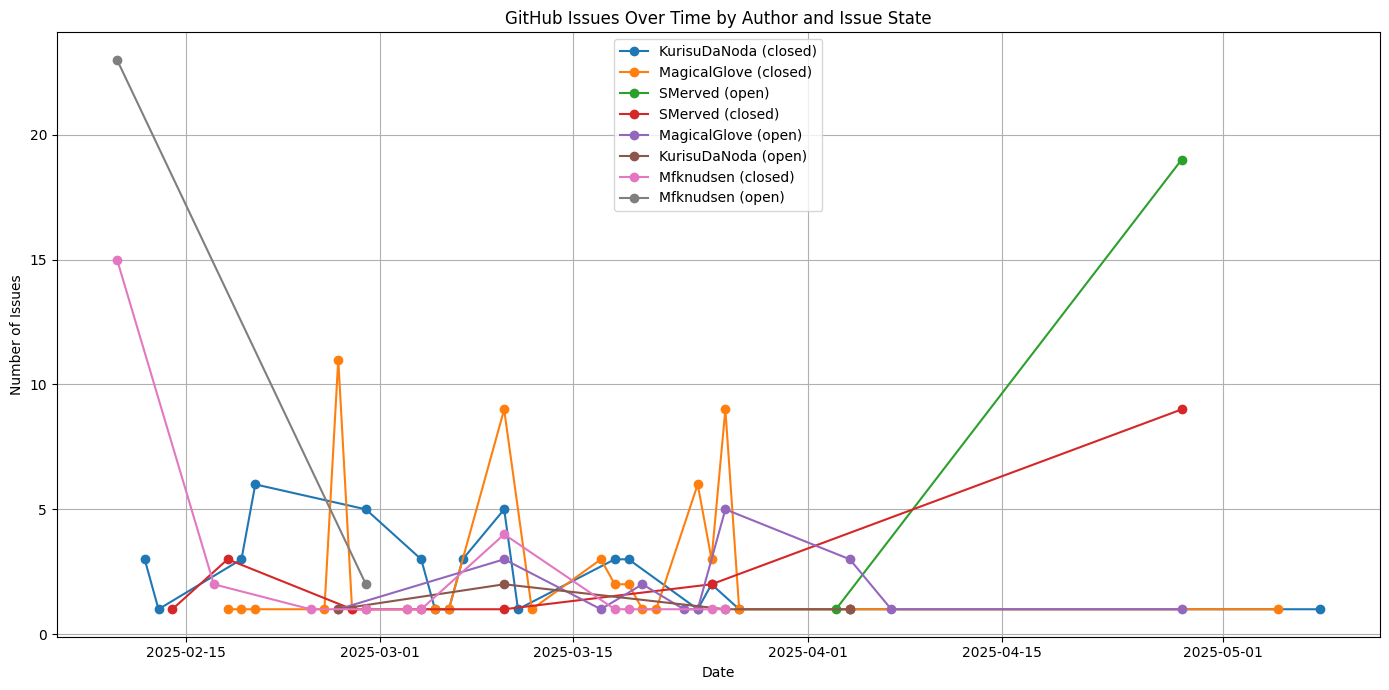

In [61]:
# Get issues (excluding PRs)
def get_issues(owner, repo, max_pages=100):
    issues = []
    page = 1
    while page <= max_pages:
        url = f"https://api.github.com/repos/{owner}/{repo}/issues"
        params = {
            "state": "all",
            "per_page": 100,
            "page": page
        }
        response = requests.get(url, headers=headers, params=params)
        if response.status_code != 200:
            break
        data = response.json()
        if not data:
            break
        for issue in data:
            # Filter out pull requests (they show up as issues too)
            if 'pull_request' not in issue:
                issues.append(issue)
        page += 1
    return issues

# Extract (author, date, state) from issues
def extract_author_issue_dates(issues):
    author_dates = []
    for issue in issues:
        user = issue.get("user", {})
        author = user.get("login", "")
        if author in ALLOWED_AUTHORS:
            date = issue["created_at"][:10]  # YYYY-MM-DD
            state = issue["state"]
            author_dates.append((author, date, state))
    return author_dates

# Count issues per author per date
def count_issues_by_author_date(author_dates):
    author_date_counts = defaultdict(Counter)
    for author, date, state in author_dates:
        key = f"{author} ({state})"
        author_date_counts[key][date] += 1
    return author_date_counts

# Plot issues over time
def plot_issues(author_date_counts):
    plt.figure(figsize=(14, 7))
    for author_state, date_counts in author_date_counts.items():
        dates = sorted(date_counts)
        counts = [date_counts[date] for date in dates]
        date_objs = [datetime.strptime(date, "%Y-%m-%d") for date in dates]
        plt.plot(date_objs, counts, label=author_state, marker='o')

    plt.title("GitHub Issues Over Time by Author and Issue State")
    plt.xlabel("Date")
    plt.ylabel("Number of Issues")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

issues = get_issues(OWNER, REPO)
author_dates = extract_author_issue_dates(issues)
author_date_counts = count_issues_by_author_date(author_dates)
plot_issues(author_date_counts)

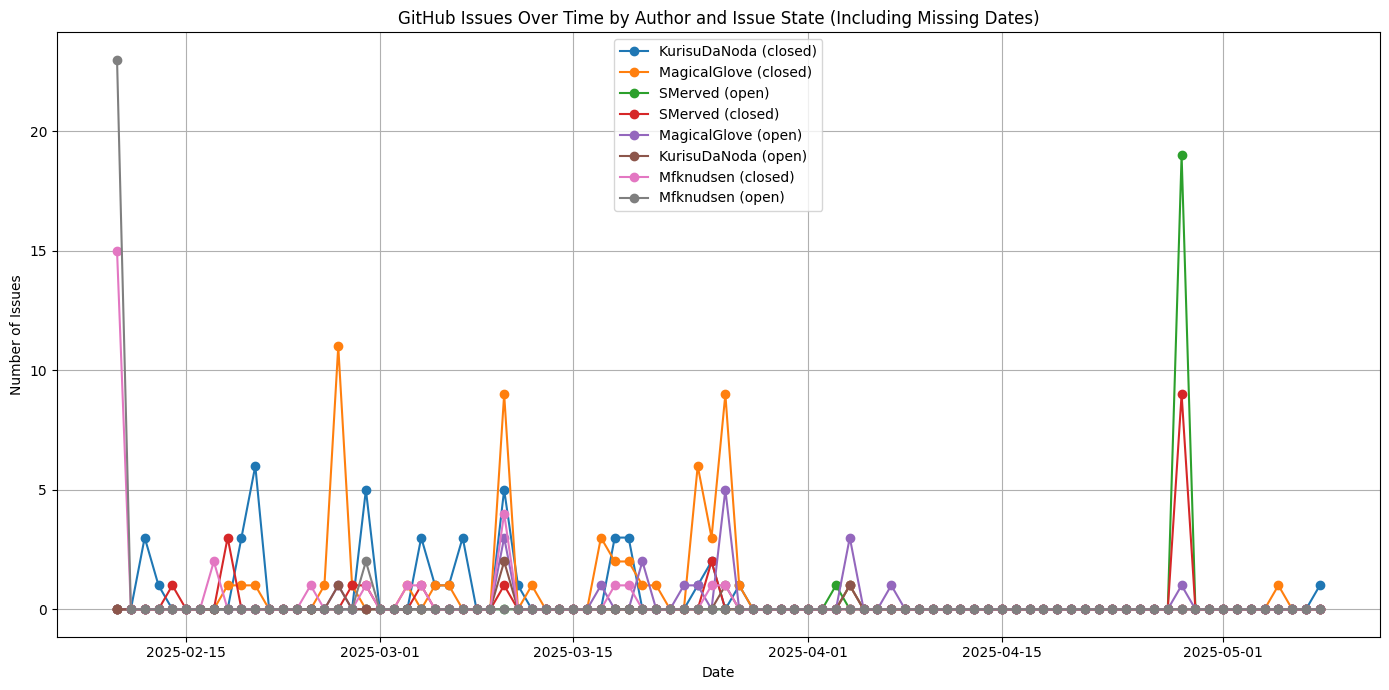

In [ ]:

def fill_missing_issue_dates_by_author(author_date_counts):
    all_dates = set()
    for date_counts in author_date_counts.values():
        all_dates.update(date_counts.keys())
    all_dates = sorted(all_dates)  # Sort dates in ascending order

    # Create a complete date range from the earliest to the latest date
    if not all_dates:
        return author_date_counts  # Return as-is if no data
    start_date = datetime.strptime(all_dates[0], "%Y-%m-%d")
    end_date = datetime.strptime(all_dates[-1], "%Y-%m-%d")
    full_date_range = [(start_date + timedelta(days=i)).strftime("%Y-%m-%d")
                       for i in range((end_date - start_date).days + 1)]

    for author, date_counts in author_date_counts.items():
        for date in full_date_range:
            if date not in date_counts:
                date_counts[date] = 0

    return author_date_counts

def plot_issues_with_filled_dates(author_date_counts):
    plt.figure(figsize=(14, 7))

    for author_state, date_counts in author_date_counts.items():
        dates = sorted(date_counts)
        counts = [date_counts[date] for date in dates]
        date_objs = [datetime.strptime(date, "%Y-%m-%d") for date in dates]
        plt.plot(date_objs, counts, label=author_state, marker='o')

    plt.title("GitHub Issues Over Time by Author and Issue State (Including Missing Dates)")
    plt.xlabel("Date")
    plt.ylabel("Number of Issues")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Run full process
issues = get_issues(OWNER, REPO)
author_dates = extract_author_issue_dates(issues)
author_date_counts = count_issues_by_author_date(author_dates)
filled_author_date_counts = fill_missing_issue_dates_by_author(author_date_counts)
plot_issues_with_filled_dates(filled_author_date_counts)

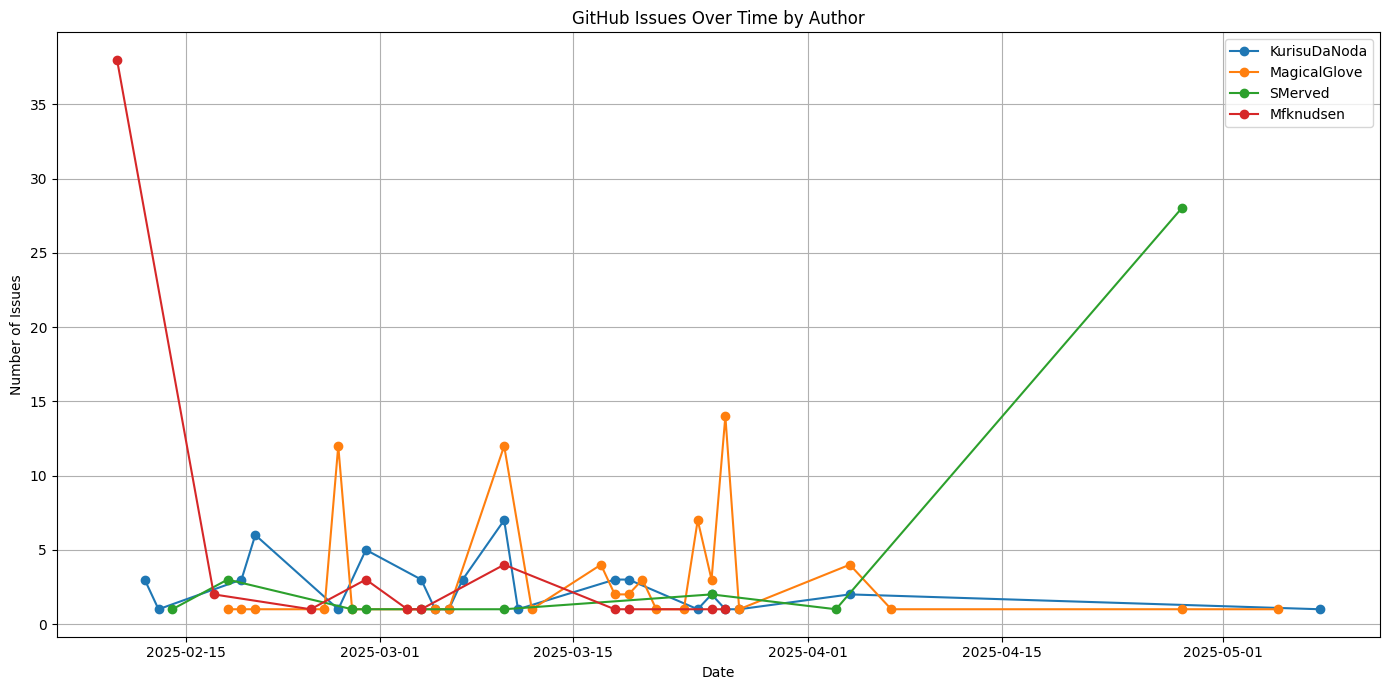

In [ ]:
# Get issues (excluding PRs)
def get_issues(owner, repo, max_pages=100):
    issues = []
    page = 1
    while page <= max_pages:
        url = f"https://api.github.com/repos/{owner}/{repo}/issues"
        params = {
            "state": "all",
            "per_page": 100,
            "page": page
        }
        response = requests.get(url, headers=headers, params=params)
        if response.status_code != 200:
            break
        data = response.json()
        if not data:
            break
        for issue in data:
            # Filter out pull requests (they show up as issues too)
            if 'pull_request' not in issue:
                issues.append(issue)
        page += 1
    return issues

# Extract (author, date, state) from issues
def extract_author_issue_dates(issues):
    author_dates = []   
    for issue in issues:
        user = issue.get("user", {})
        author = user.get("login", "")
        if author in ALLOWED_AUTHORS:
            date = issue["created_at"][:10]  # YYYY-MM-DD
            state = issue["state"]
            author_dates.append((author, date, state))
    return author_dates

# Count issues per author per date
def count_issues_by_author_date(author_dates):
    author_date_counts = defaultdict(Counter)
    for author, date, state in author_dates:
        author_date_counts[author][date] += 1  # Just use author
    return author_date_counts

# Plot issues over time
def plot_issues(author_date_counts):
    plt.figure(figsize=(14, 7))
    for author_state, date_counts in author_date_counts.items():
        dates = sorted(date_counts)
        counts = [date_counts[date] for date in dates]
        date_objs = [datetime.strptime(date, "%Y-%m-%d") for date in dates]
        plt.plot(date_objs, counts, label=author_state, marker='o')

    plt.title("GitHub Issues Over Time by Author")
    plt.xlabel("Date")
    plt.ylabel("Number of Issues")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

issues = get_issues(OWNER, REPO)
author_dates = extract_author_issue_dates(issues)
author_date_counts = count_issues_by_author_date(author_dates)
plot_issues(author_date_counts)

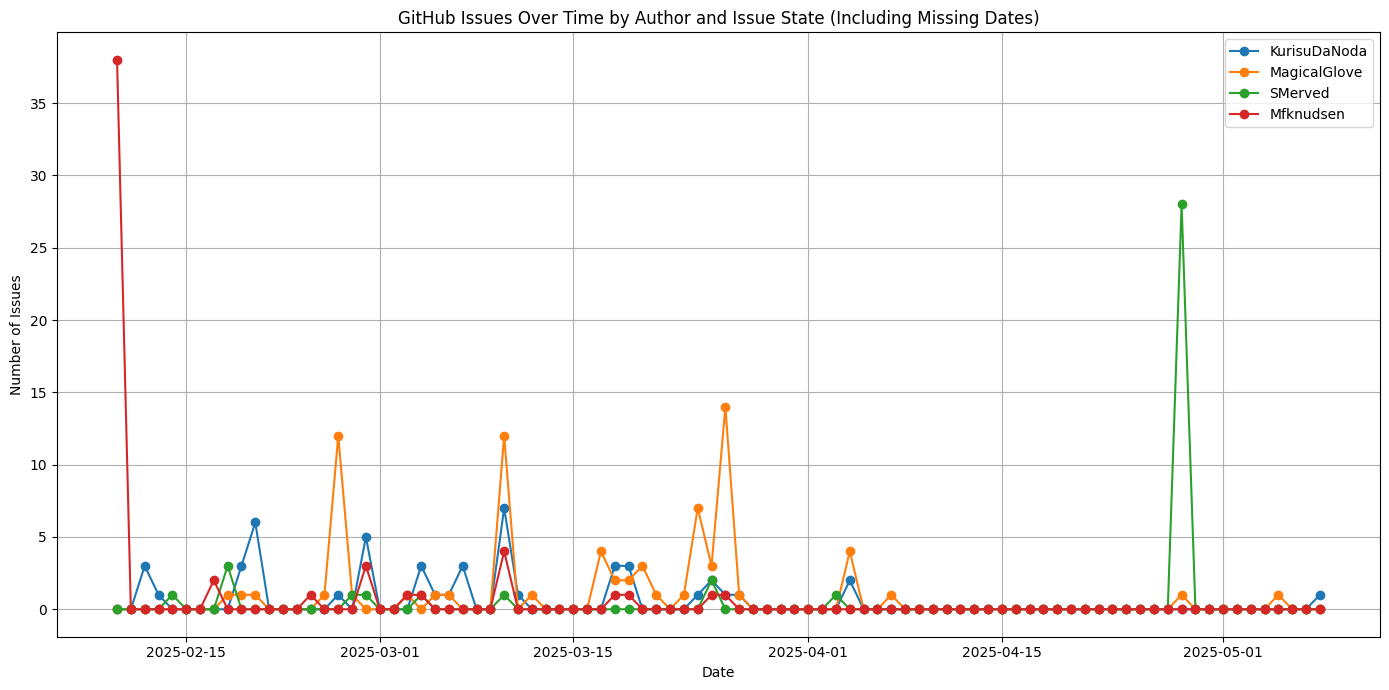

In [ ]:

def fill_missing_issue_dates_by_author(author_date_counts):
    all_dates = set()
    for date_counts in author_date_counts.values():
        all_dates.update(date_counts.keys())
    all_dates = sorted(all_dates)  # Sort dates in ascending order

    # Create a complete date range from the earliest to the latest date
    if not all_dates:
        return author_date_counts  # Return as-is if no data
    start_date = datetime.strptime(all_dates[0], "%Y-%m-%d")
    end_date = datetime.strptime(all_dates[-1], "%Y-%m-%d")
    full_date_range = [(start_date + timedelta(days=i)).strftime("%Y-%m-%d")
                       for i in range((end_date - start_date).days + 1)]

    # Fill missing dates with 0 for each author
    for author, date_counts in author_date_counts.items():
        for date in full_date_range:
            if date not in date_counts:
                date_counts[date] = 0

    return author_date_counts

def plot_issues_with_filled_dates(author_date_counts):
    plt.figure(figsize=(14, 7))

    for author_state, date_counts in author_date_counts.items():
        dates = sorted(date_counts)
        counts = [date_counts[date] for date in dates]
        date_objs = [datetime.strptime(date, "%Y-%m-%d") for date in dates]
        plt.plot(date_objs, counts, label=author_state, marker='o')

    plt.title("GitHub Issues Over Time by Author and Issue State (Including Missing Dates)")
    plt.xlabel("Date")
    plt.ylabel("Number of Issues")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Run full process
issues = get_issues(OWNER, REPO)
author_dates = extract_author_issue_dates(issues)
author_date_counts = count_issues_by_author_date(author_dates)
filled_author_date_counts = fill_missing_issue_dates_by_author(author_date_counts)
plot_issues_with_filled_dates(filled_author_date_counts)

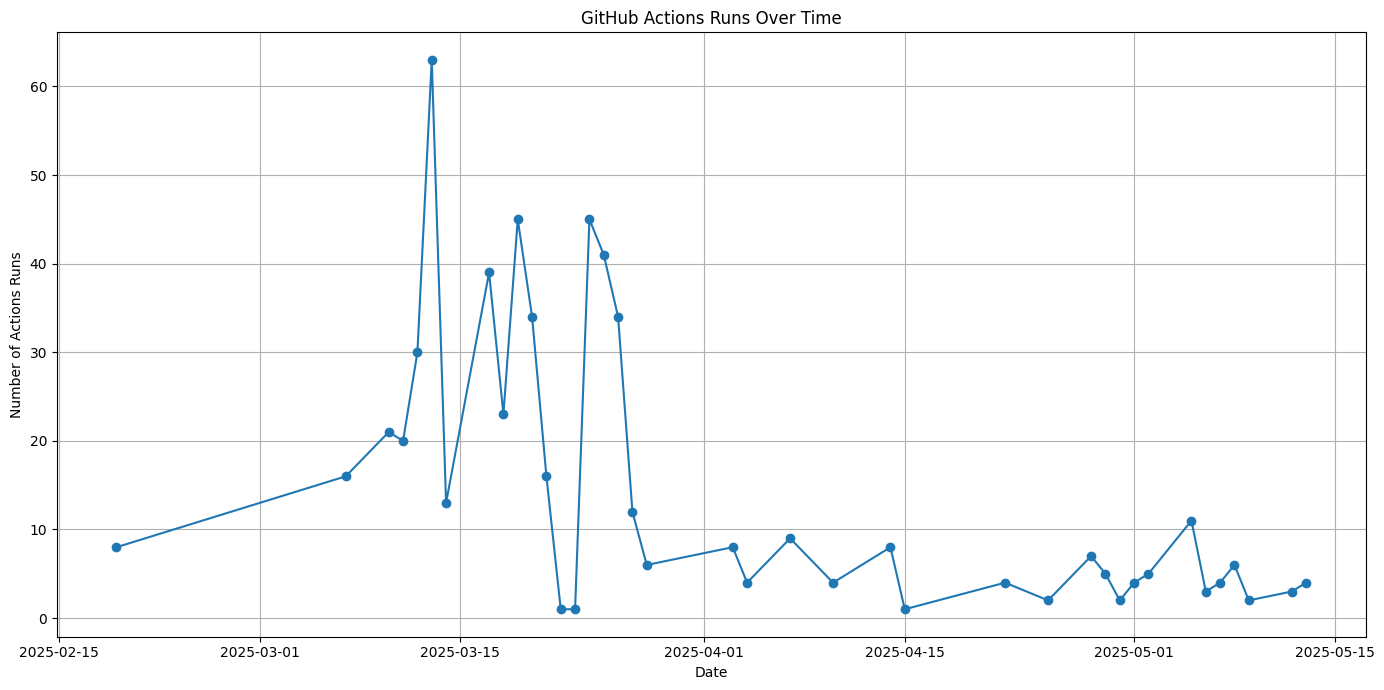

In [87]:
# Get GitHub Actions runs
def get_actions_runs(owner, repo, max_pages=100):
    runs = []
    page = 1
    while page <= max_pages:
        url = f"https://api.github.com/repos/{owner}/{repo}/actions/runs"
        params = {
            "per_page": 100,
            "page": page
        }
        response = requests.get(url, headers=headers, params=params)
        if response.status_code != 200:
            break
        data = response.json()
        if not data.get('workflow_runs'):
            break
        runs.extend(data['workflow_runs'])
        page += 1
    return runs

# Extract (date) from the workflow runs (without filtering by author)
def extract_run_dates(runs):
    run_dates = []
    for run in runs:
        date = run['created_at'][:10]  # YYYY-MM-DD
        run_dates.append(date)
    return run_dates

# Count actions runs per date (no author grouping)
def count_runs_by_date(run_dates):
    date_counts = Counter(run_dates)
    return date_counts

# Plot actions runs over time
def plot_actions_runs(date_counts):
    plt.figure(figsize=(14, 7))
    dates = sorted(date_counts)
    counts = [date_counts[date] for date in dates]
    date_objs = [datetime.strptime(date, "%Y-%m-%d") for date in dates]
    plt.plot(date_objs, counts, label="Total Actions Runs", marker='o')

    plt.title("GitHub Actions Runs Over Time")
    plt.xlabel("Date")
    plt.ylabel("Number of Actions Runs")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

runs = get_actions_runs(OWNER, REPO)
run_dates = extract_run_dates(runs)
date_counts = count_runs_by_date(run_dates)
plot_actions_runs(date_counts)


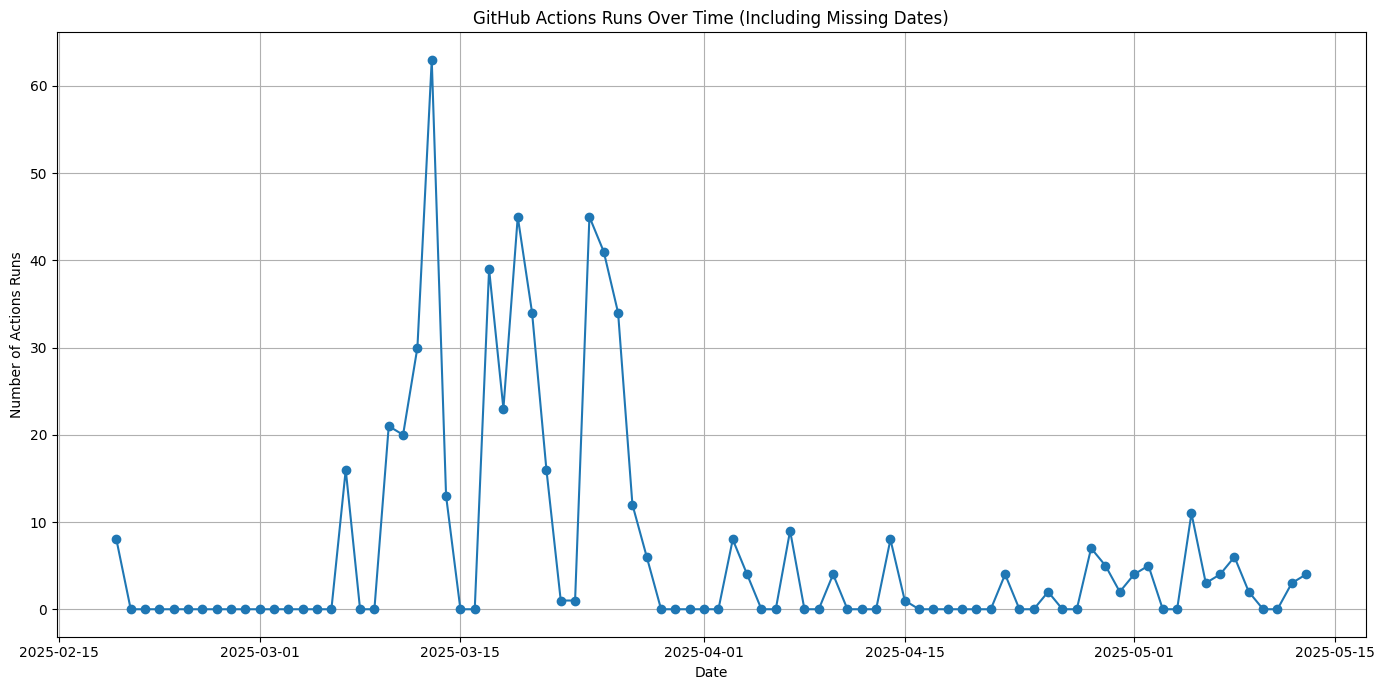

In [86]:
from datetime import timedelta

# Fill missing dates with 0 values
def fill_missing_action_run_dates(date_counts):
    # Determine the full range of dates
    all_dates = sorted(date_counts.keys())  # Sort dates in ascending order
    if not all_dates:
        return date_counts  # Return as-is if no data

    start_date = datetime.strptime(all_dates[0], "%Y-%m-%d")
    end_date = datetime.strptime(all_dates[-1], "%Y-%m-%d")
    full_date_range = [(start_date + timedelta(days=i)).strftime("%Y-%m-%d")
                       for i in range((end_date - start_date).days + 1)]

    # Fill missing dates with 0
    for date in full_date_range:
        if date not in date_counts:
            date_counts[date] = 0

    return date_counts

# Updated plotting function
def plot_actions_runs_with_filled_dates(date_counts):
    plt.figure(figsize=(14, 7))
    dates = sorted(date_counts)
    counts = [date_counts[date] for date in dates]
    date_objs = [datetime.strptime(date, "%Y-%m-%d") for date in dates]
    plt.plot(date_objs, counts, label="Total Actions Runs", marker='o')

    plt.title("GitHub Actions Runs Over Time (Including Missing Dates)")
    plt.xlabel("Date")
    plt.ylabel("Number of Actions Runs")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Process and plot
runs = get_actions_runs(OWNER, REPO)
run_dates = extract_run_dates(runs)
date_counts = count_runs_by_date(run_dates)
filled_date_counts = fill_missing_action_run_dates(date_counts)
plot_actions_runs_with_filled_dates(filled_date_counts)

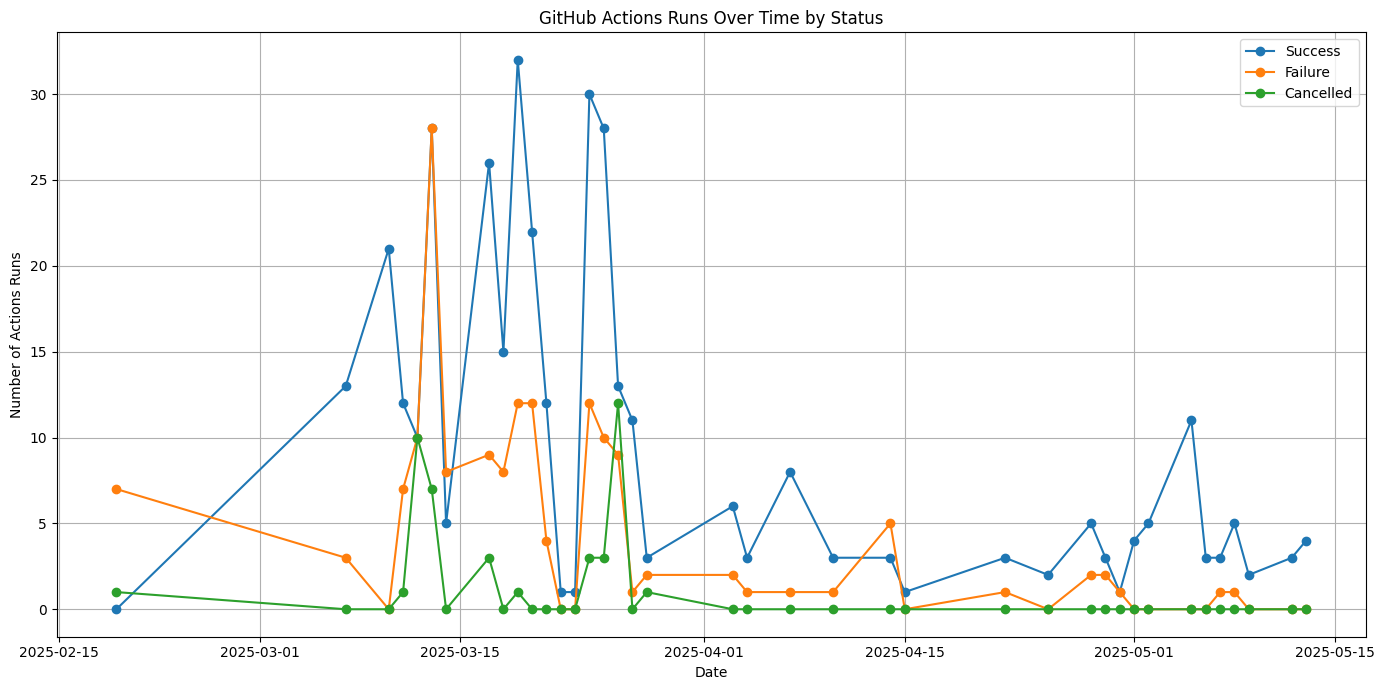

In [67]:
# Get GitHub Actions runs by status
def get_actions_runs(owner, repo, max_pages=100):
    runs = []
    page = 1
    while page <= max_pages:
        url = f"https://api.github.com/repos/{owner}/{repo}/actions/runs"
        params = {
            "per_page": 100,
            "page": page
        }
        response = requests.get(url, headers=headers, params=params)
        if response.status_code != 200:
            break
        data = response.json()
        if not data.get('workflow_runs'):
            break
        runs.extend(data['workflow_runs'])
        page += 1
    return runs

# Extract (date, result status) from the workflow runs
def extract_run_dates_and_status(runs):
    run_dates_status = []
    for run in runs:
        date = run['created_at'][:10]  # YYYY-MM-DD
        status = run['conclusion']  # Status: 'success', 'failure', 'neutral', etc.
        run_dates_status.append((date, status))
    return run_dates_status

# Count actions runs per date and status
def count_runs_by_date_and_status(run_dates_status):
    date_status_counts = defaultdict(lambda: Counter())
    for date, status in run_dates_status:
        date_status_counts[date][status] += 1
    return date_status_counts

# Plot actions runs over time grouped by status
def plot_actions_runs(date_status_counts):
    plt.figure(figsize=(14, 7))

    # Loop over each status and plot
    for status in ['success', 'failure', 'cancelled']:  # Add other statuses as needed
        dates = sorted(date_status_counts)
        counts = [date_status_counts[date].get(status, 0) for date in dates]
        date_objs = [datetime.strptime(date, "%Y-%m-%d") for date in dates]
        plt.plot(date_objs, counts, label=status.capitalize(), marker='o')

    plt.title("GitHub Actions Runs Over Time by Status")
    plt.xlabel("Date")
    plt.ylabel("Number of Actions Runs")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

runs = get_actions_runs(OWNER, REPO)
run_dates_status = extract_run_dates_and_status(runs)
date_status_counts = count_runs_by_date_and_status(run_dates_status)
plot_actions_runs(date_status_counts)


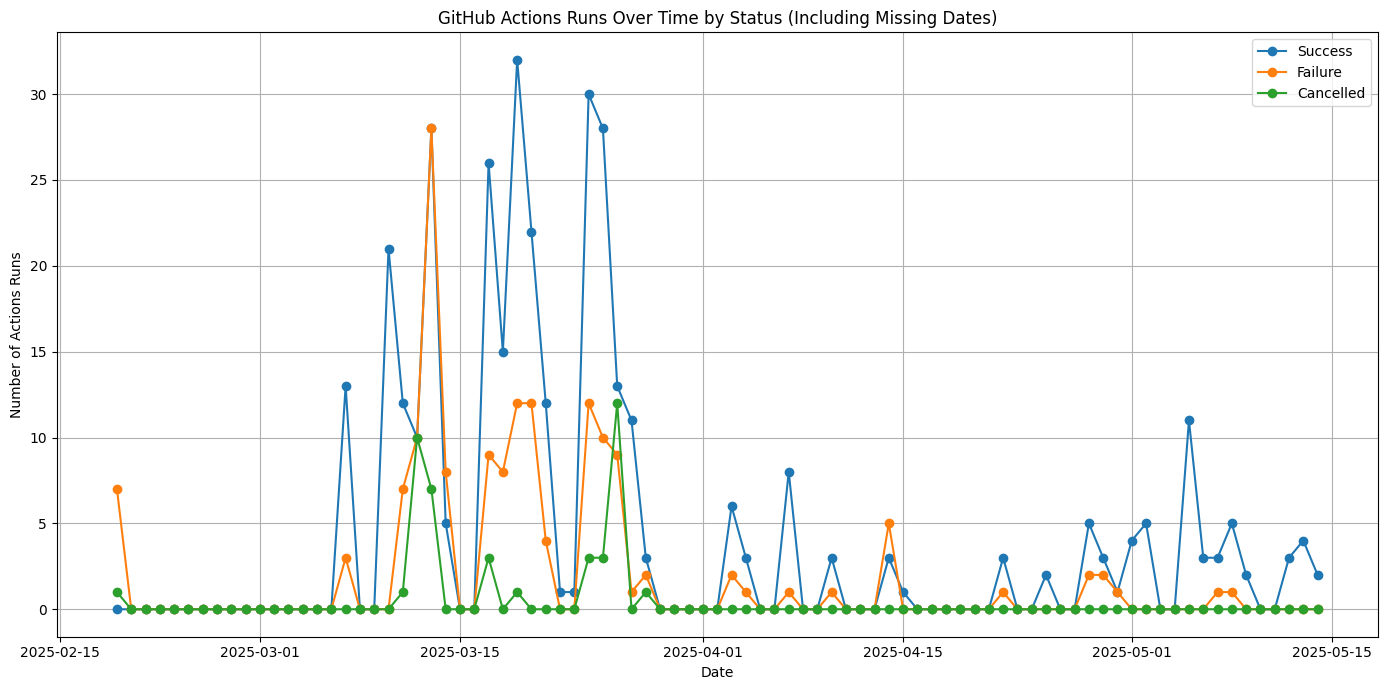

In [92]:
def fill_missing_dates(date_status_counts):
    if not date_status_counts:
        return date_status_counts

    all_dates = sorted(date_status_counts)
    start_date = datetime.strptime(all_dates[0], "%Y-%m-%d")
    end_date = datetime.strptime(all_dates[-1], "%Y-%m-%d")
    current_date = start_date

    while current_date <= end_date:
        date_str = current_date.strftime("%Y-%m-%d")
        if date_str not in date_status_counts:
            date_status_counts[date_str] = Counter()
        current_date += timedelta(days=1)

    return date_status_counts

def plot_actions_runs(date_status_counts):
    plt.figure(figsize=(14, 7))

    # Loop over each status and plot
    for status in ['success', 'failure', 'cancelled']:  # Add other statuses as needed
        dates = sorted(date_status_counts)
        counts = [date_status_counts[date].get(status, 0) for date in dates]
        date_objs = [datetime.strptime(date, "%Y-%m-%d") for date in dates]
        plt.plot(date_objs, counts, label=status.capitalize(), marker='o')

    plt.title("GitHub Actions Runs Over Time by Status (Including Missing Dates)")
    plt.xlabel("Date")
    plt.ylabel("Number of Actions Runs")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


runs = get_actions_runs(OWNER, REPO)
run_dates_status = extract_run_dates_and_status(runs)
date_status_counts = count_runs_by_date_and_status(run_dates_status)
date_status_counts = fill_missing_dates(date_status_counts)
plot_actions_runs(date_status_counts)

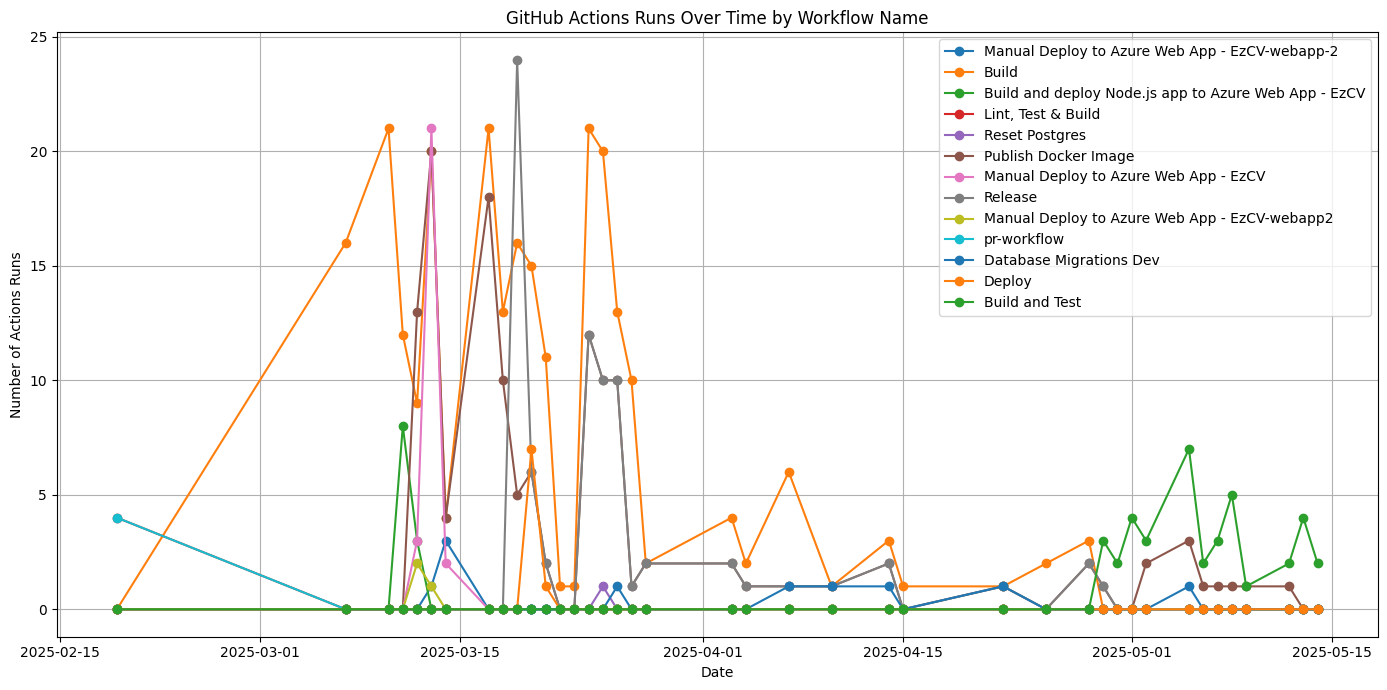

In [91]:
def get_actions_runs(owner, repo, max_pages=100):
    runs = []
    page = 1
    while page <= max_pages:
        url = f"https://api.github.com/repos/{owner}/{repo}/actions/runs"
        params = {
            "per_page": 100,
            "page": page
        }
        response = requests.get(url, headers=headers, params=params)
        if response.status_code != 200:
            break
        data = response.json()
        if not data.get('workflow_runs'):
            break
        runs.extend(data['workflow_runs'])
        page += 1
    return runs

def extract_run_dates_and_names(runs):
    run_dates_names = []
    for run in runs:
        date = run['created_at'][:10]  # YYYY-MM-DD
        name = run['name']  # Workflow name
        run_dates_names.append((date, name))
    return run_dates_names

def count_runs_by_date_and_name(run_dates_names):
    date_name_counts = defaultdict(lambda: Counter())
    for date, name in run_dates_names:
        date_name_counts[date][name] += 1
    return date_name_counts

def plot_actions_runs(date_name_counts):
    plt.figure(figsize=(14, 7))

    workflow_names = list({name for date in date_name_counts for name in date_name_counts[date]})
    for name in workflow_names:
        dates = sorted(date_name_counts)
        counts = [date_name_counts[date].get(name, 0) for date in dates]
        date_objs = [datetime.strptime(date, "%Y-%m-%d") for date in dates]
        plt.plot(date_objs, counts, label=name, marker='o')

    plt.title("GitHub Actions Runs Over Time by Workflow Name")
    plt.xlabel("Date")
    plt.ylabel("Number of Actions Runs")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

runs = get_actions_runs(OWNER, REPO)
run_dates_names = extract_run_dates_and_names(runs)
date_name_counts = count_runs_by_date_and_name(run_dates_names)
plot_actions_runs(date_name_counts)


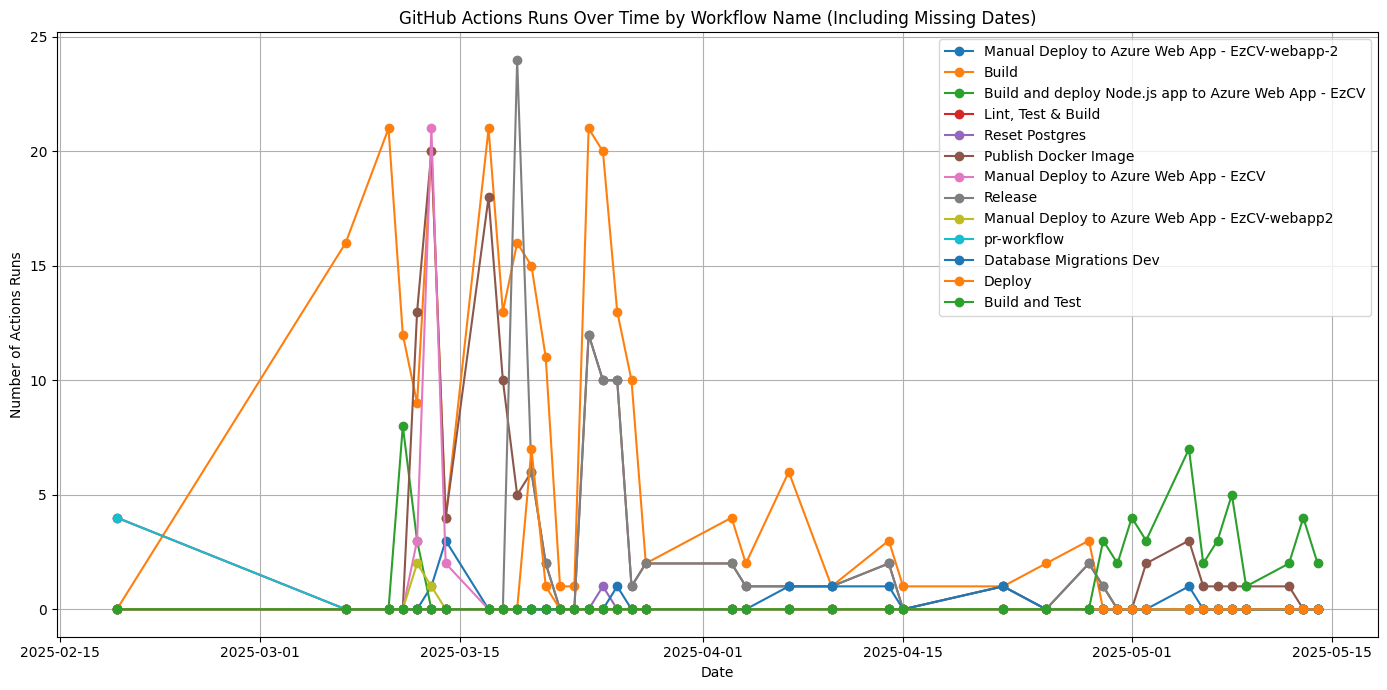

In [90]:
from datetime import datetime, timedelta

# Fill missing dates with 0 values for each workflow name
def fill_missing_dates_by_workflow(date_name_counts):
    # Collect all unique dates
    all_dates = set()
    for date_counts in date_name_counts.values():
        all_dates.update(date_counts.keys())
    
    # Filter out invalid dates
    def is_valid_date(date_string):
        try:
            datetime.strptime(date_string, "%Y-%m-%d")
            return True
        except ValueError:
            return False

    all_dates = sorted([date for date in all_dates if is_valid_date(date)])  # Keep only valid dates

    # If no valid dates, return the input as-is
    if not all_dates:
        return date_name_counts

    # Create a complete date range
    start_date = datetime.strptime(all_dates[0], "%Y-%m-%d")
    end_date = datetime.strptime(all_dates[-1], "%Y-%m-%d")
    full_date_range = [(start_date + timedelta(days=i)).strftime("%Y-%m-%d")
                       for i in range((end_date - start_date).days + 1)]

    # Fill missing dates with 0 for each workflow name
    for workflow_name, date_counts in date_name_counts.items():
        for date in full_date_range:
            if date not in date_counts:
                date_counts[date] = 0

    return date_name_counts

# Updated plotting function
def plot_actions_runs_with_filled_dates(date_name_counts):
    plt.figure(figsize=(14, 7))

    # Extract workflow names
    workflow_names = list({name for date_counts in date_name_counts.values() for name in date_counts.keys()})
    for name in workflow_names:
        dates = sorted(date_name_counts.keys())
        counts = [date_name_counts[date].get(name, 0) for date in dates]
        date_objs = [datetime.strptime(date, "%Y-%m-%d") for date in dates]
        plt.plot(date_objs, counts, label=name, marker='o')

    plt.title("GitHub Actions Runs Over Time by Workflow Name (Including Missing Dates)")
    plt.xlabel("Date")
    plt.ylabel("Number of Actions Runs")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Process and plot
runs = get_actions_runs(OWNER, REPO)
run_dates_names = extract_run_dates_and_names(runs)
date_name_counts = count_runs_by_date_and_name(run_dates_names)
filled_date_name_counts = fill_missing_dates_by_workflow(date_name_counts)
plot_actions_runs_with_filled_dates(filled_date_name_counts)

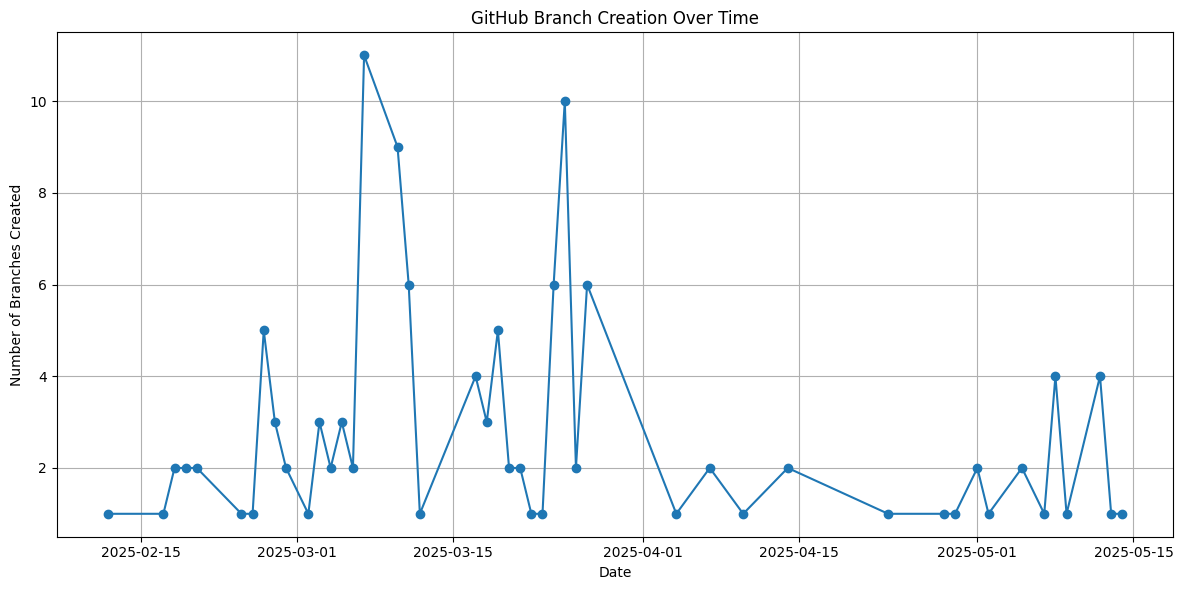

In [89]:
# Get branches from the GitHub API
def get_branches(owner, repo):
    branches = []
    page = 1
    per_page = 100  # Max per GitHub's limit

    while True:
        url = f"https://api.github.com/repos/{owner}/{repo}/branches?page={page}&per_page={per_page}"
        response = requests.get(url, headers=headers)
        if response.status_code != 200:
            print(f"Failed to fetch branches on page {page}")
            break

        data = response.json()
        if not data:
            break

        branches.extend(data)
        page += 1

    return branches

# Get commit date of the branch head
def get_commit_date(url):
    response = requests.get(url, headers=headers)
    if response.status_code != 200:
        return None
    data = response.json()
    return data['commit']['author']['date'][:10]  # YYYY-MM-DD

# Get approximate creation dates for all branches
def get_branch_creation_dates(owner, repo):
    branches = get_branches(owner, repo)
    creation_dates = []
    for branch in branches:
        url = branch['commit']['url']
        date = get_commit_date(url)
        if date:
            creation_dates.append(date)
    return creation_dates

# Count branches created per date
def count_branches_by_date(dates):
    counter = Counter(dates)
    return sorted(counter.items())

# Plot the graph
def plot_branch_history(branch_data):
    if not branch_data:
        print("No branch data to plot.")
        return
    dates, counts = zip(*branch_data)
    dates = [datetime.strptime(date, "%Y-%m-%d") for date in dates]
    plt.figure(figsize=(12, 6))
    plt.plot(dates, counts, marker='o', linestyle='-')
    plt.title("GitHub Branch Creation Over Time")
    plt.xlabel("Date")
    plt.ylabel("Number of Branches Created")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

branch_dates = get_branch_creation_dates(OWNER, REPO)
branch_data = count_branches_by_date(branch_dates)
plot_branch_history(branch_data)

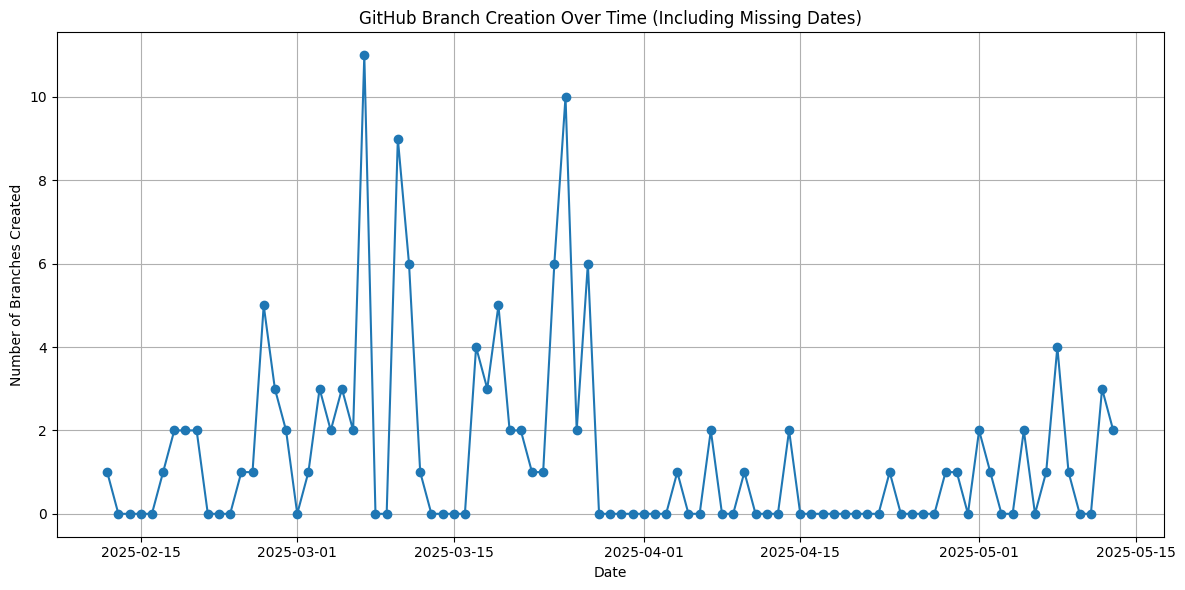

In [ ]:
def fill_missing_branch_dates(branch_date_counts):
    all_dates = sorted(branch_date_counts.keys())  # Sort dates in ascending order
    if not all_dates:
        return branch_date_counts  # Return as-is if no data

    start_date = datetime.strptime(all_dates[0], "%Y-%m-%d")
    end_date = datetime.strptime(all_dates[-1], "%Y-%m-%d")
    full_date_range = [(start_date + timedelta(days=i)).strftime("%Y-%m-%d")
                       for i in range((end_date - start_date).days + 1)]

    for date in full_date_range:
        if date not in branch_date_counts:
            branch_date_counts[date] = 0

    return branch_date_counts

def plot_branch_history_with_filled_dates(branch_date_counts):
    if not branch_date_counts:
        print("No branch data to plot.")
        return
    dates = sorted(branch_date_counts)
    counts = [branch_date_counts[date] for date in dates]
    date_objs = [datetime.strptime(date, "%Y-%m-%d") for date in dates]
    plt.figure(figsize=(12, 6))
    plt.plot(date_objs, counts, marker='o', linestyle='-')
    plt.title("GitHub Branch Creation Over Time (Including Missing Dates)")
    plt.xlabel("Date")
    plt.ylabel("Number of Branches Created")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Process and plot
branch_dates = get_branch_creation_dates(OWNER, REPO)
branch_date_counts = dict(Counter(branch_dates))  # Convert to dictionary for easier manipulation
filled_branch_date_counts = fill_missing_branch_dates(branch_date_counts)
plot_branch_history_with_filled_dates(filled_branch_date_counts)

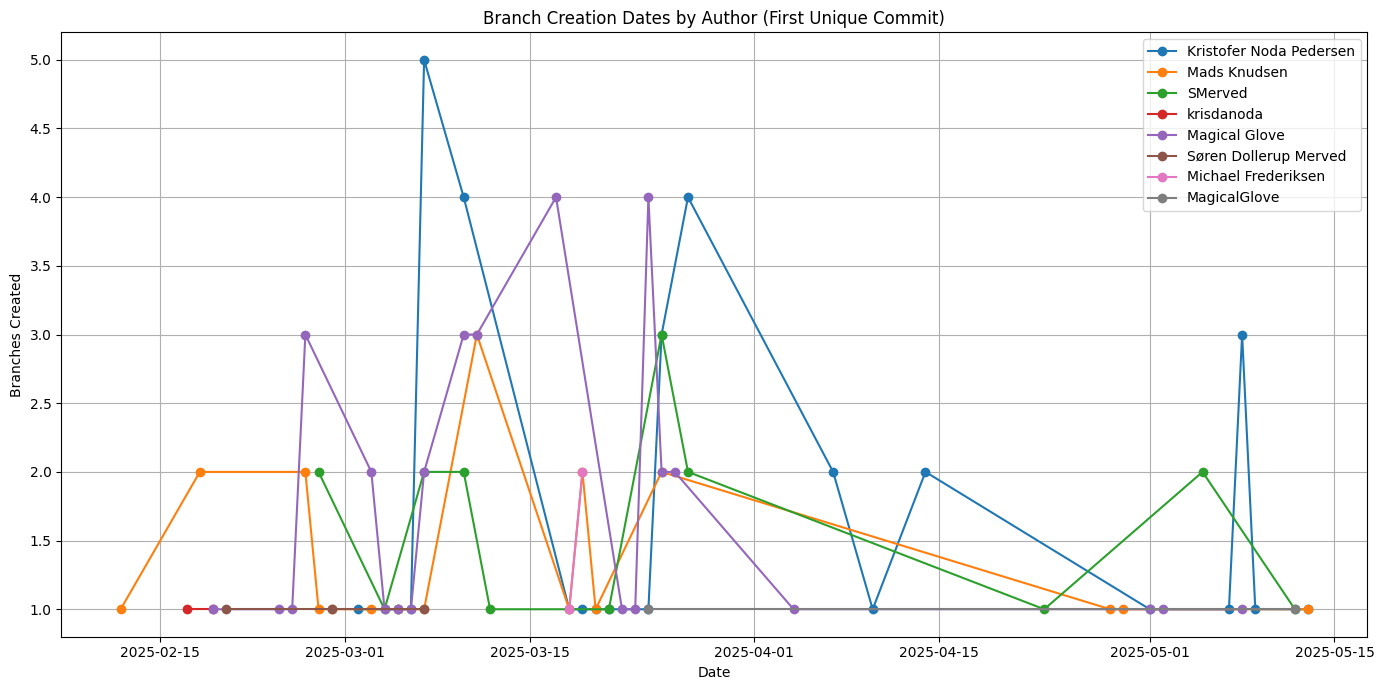

In [83]:
def get_branches(owner, repo):
    branches = []
    page = 1
    per_page = 100  # Max per GitHub's limit

    while True:
        url = f"https://api.github.com/repos/{owner}/{repo}/branches?page={page}&per_page={per_page}"
        response = requests.get(url, headers=headers)
        if response.status_code != 200:
            print(f"Failed to fetch branches on page {page}")
            break

        data = response.json()
        if not data:
            break

        branches.extend(data)
        page += 1

    return branches

def get_first_commit(url):
    response = requests.get(url, headers=headers)
    if response.status_code != 200:
        return []
    return response.json()

def get_branch_author_dates(owner, repo, base_branch):
    branches = get_branches(owner, repo)
    author_dates = []
    for branch in branches:
        branch_name = branch['name']
        if branch_name == base_branch:
            continue
        first_commit = get_first_commit(branch['commit']['url'])
        name = first_commit['commit']['author']['name']
        if name in ALLOWED_AUTHORS:
            date = first_commit['commit']['author']['date'][:10]
            author_dates.append((name, date))
    return author_dates

def count_branches_by_author(author_dates):
    author_counter = defaultdict(Counter)
    for author, date in author_dates:
        author_counter[author][date] += 1
    return author_counter

def plot_branches_by_author(author_counter):
    plt.figure(figsize=(14, 7))
    for author, date_counts in author_counter.items():
        dates, counts = zip(*sorted(date_counts.items()))
        dates = [datetime.strptime(d, "%Y-%m-%d") for d in dates]
        plt.plot(dates, counts, marker='o', label=author)
    plt.title("Branch Creation Dates by Author (First Unique Commit)")
    plt.xlabel("Date")
    plt.ylabel("Branches Created")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

author_dates = get_branch_author_dates(OWNER, REPO, 'main')
author_counter = count_branches_by_author(author_dates)
plot_branches_by_author(author_counter)

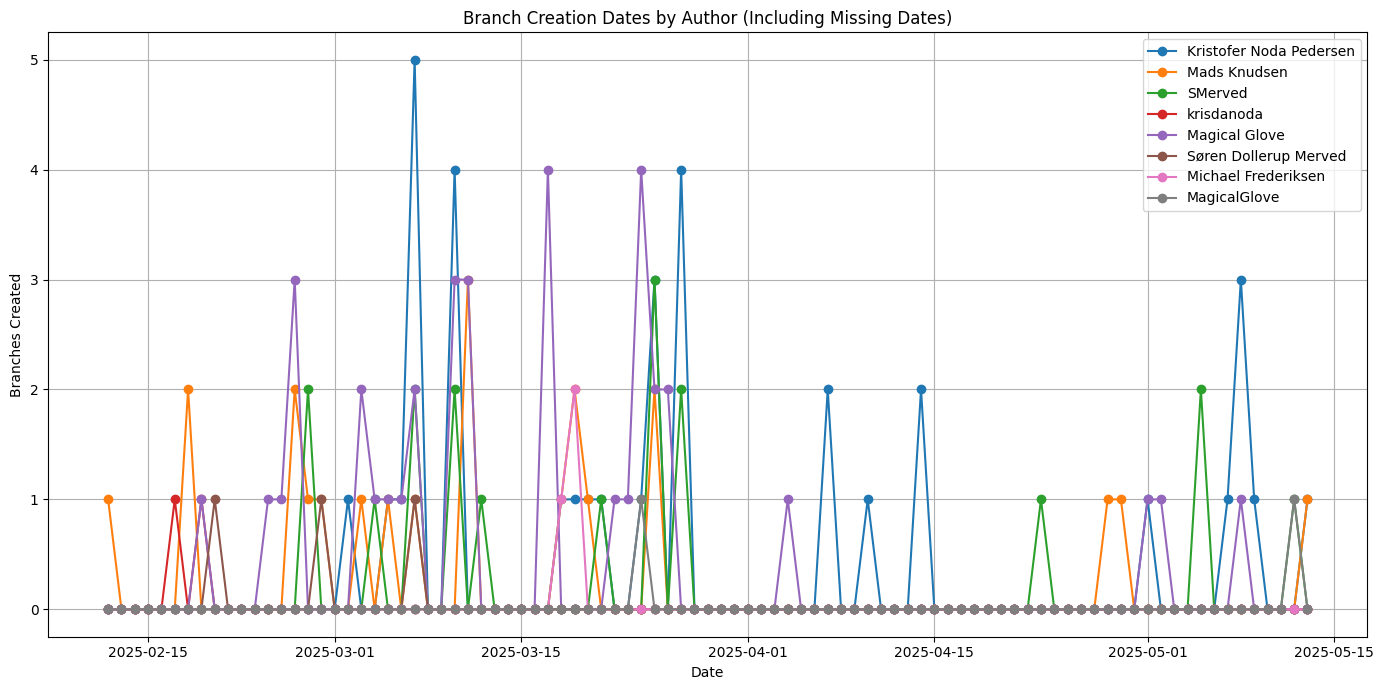

In [84]:

def fill_missing_branch_dates(author_counter):
    # Determine the full range of dates
    all_dates = set()
    for date_counts in author_counter.values():
        all_dates.update(date_counts.keys())
    all_dates = sorted(all_dates)  # Sort dates in ascending order

    if not all_dates:
        return author_counter  # Return as-is if no data
    start_date = datetime.strptime(all_dates[0], "%Y-%m-%d")
    end_date = datetime.strptime(all_dates[-1], "%Y-%m-%d")
    full_date_range = [(start_date + timedelta(days=i)).strftime("%Y-%m-%d")
                       for i in range((end_date - start_date).days + 1)]

    for author, date_counts in author_counter.items():
        for date in full_date_range:
            if date not in date_counts:
                date_counts[date] = 0

    return author_counter

def plot_branches_by_author_with_filled_dates(author_counter):
    plt.figure(figsize=(14, 7))
    for author, date_counts in author_counter.items():
        dates, counts = zip(*sorted(date_counts.items()))
        dates = [datetime.strptime(d, "%Y-%m-%d") for d in dates]
        plt.plot(dates, counts, marker='o', label=author)
    plt.title("Branch Creation Dates by Author (Including Missing Dates)")
    plt.xlabel("Date")
    plt.ylabel("Branches Created")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Process and plot
author_dates = get_branch_author_dates(OWNER, REPO, 'main')
author_counter = count_branches_by_author(author_dates)
filled_author_counter = fill_missing_branch_dates(author_counter)
plot_branches_by_author_with_filled_dates(filled_author_counter)